In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2016,7,25)
timeStart = datetime.datetime(2016,7,25,3,0)
timeEnd = datetime.datetime(2016,7,25,7,0)
sapsTime = datetime.datetime(2016,7,25,5,50)
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]
sapsMlatRange = [ 52., 62. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam
azimPrcntCntCutoff= 33.
nAzimsCutoff = 5

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20160725,200,0,0,-31.8579,0.0000,38.6897,-146.2574,11.4109,43.7946,142.2906,41,hkw,2016-07-25 02:00:00,11.4109
1,20160725,200,0,1,-35.2038,0.0000,39.0370,-146.7567,11.3776,44.1381,141.7370,41,hkw,2016-07-25 02:00:00,11.3776
2,20160725,200,0,2,-37.7155,3.5175,39.3297,-147.2205,11.3467,44.4252,141.2232,41,hkw,2016-07-25 02:00:00,11.3467
3,20160725,200,0,3,-39.7328,6.5212,39.6014,-147.6740,11.3165,44.6902,140.7215,41,hkw,2016-07-25 02:00:00,11.3165
4,20160725,200,0,4,-41.4199,3.6386,39.8590,-148.1218,11.2866,44.9400,140.2269,41,hkw,2016-07-25 02:00:00,11.2866


In [4]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]

In [5]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

def custom_round(x, base=5):
    return int(base * round(float(x)/base))

In [6]:
# Loop though each time in the data
# to get l-shell fitted data
# store the results in an array
velSaps = []
azimSaps = []
velStd = []
azimStd = []
sapsDates = []
# Get min,median and max of saps MLAT and MLT
minSapsLat = []
medSapsLat = []
maxSapsLat = []
minSapsMLT = []
medSapsMLT = []
maxSapsMLT = []
for cTime in sapsDF["date"].unique():
#     print "time---->", sapsTime
    # Get l-shell fitted velocities from
    # the SAPS vLos at different time intervals
    lshellDF = sapsDF[ sapsDF["date"] == cTime ]
    # groupby rounded azimuth to 
    # get median vLos to Lshell fit
    lshellDF["azimRnd"] = lshellDF["azimCalcMag"].round()
    selCols = [ "vLos", "MLAT", "normMLT", "azimRnd" ]
    if lshellDF["radCode"].unique().shape[0] < 3:
        continue
    print lshellDF
    break

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


         dateStr  timeStr  beam  range  azimCalcMag      vLos     MLAT  \
164079  20160725      252     8     18      35.5234   61.4984  57.3386   
219512  20160725      252    17     23     -12.7001 -126.1150  59.9519   
219513  20160725      252    17     24     -12.9260 -143.6799  60.3394   
219524  20160725      252    18     23      -8.6501 -116.0475  60.1541   
273062  20160725      252     8     14      36.5251   54.5214  55.0459   
273063  20160725      252     8     15      37.2241   57.4622  55.3839   
273064  20160725      252     8     16      37.8988   64.6869  55.7171   
273077  20160725      252     9     13      39.4134   54.1786  54.5966   
273078  20160725      252     9     14      39.8694   58.8586  54.8306   
273079  20160725      252     9     15      40.5913   64.6869  55.1535   
273080  20160725      252     9     16      41.2909   73.2488  55.4712   
273093  20160725      252    10     13      42.6337   52.7566  54.3744   
273094  20160725      252    10     14

   radCode  beam      vLos     MLAT  normMLT  azimCalcMag
0      fhe     0   75.8700  59.9164  -1.0439      10.4109
1      fhe     1  414.0402  59.8569  -0.9559      14.7678
2      fhe     2  495.7976  60.1308  -0.8494      19.3993
3      fhe     3  428.4561  59.9712  -0.7614      23.6589
4      fhe     4  254.2500  59.7662  -0.6762      27.8303
5      fhe     5  277.3117  59.8610  -0.5629      32.4017
6      fhe     6  296.3440  59.5560  -0.4818      36.4226
7      fhe     7  303.5801  59.2104  -0.4052      40.3355
8      fhe     8  390.8667  58.8269  -0.3335      44.1377
9      fhe     9  334.7819  58.4083  -0.2669      47.8274
10     fhe    10  402.2814  58.2085  -0.1606      52.0804
14     fhw    12  -50.3376  58.2655  -1.7225     -29.6467
15     fhw    13  -74.9397  58.9525  -1.6609     -25.3968
16     fhw    14  -71.8214  59.9748  -1.5768     -20.7372
17     fhw    15 -103.8658  59.9289  -1.5134     -16.4839
18     fhw    16 -109.3557  60.1831  -1.4481     -12.2232
19     fhw    

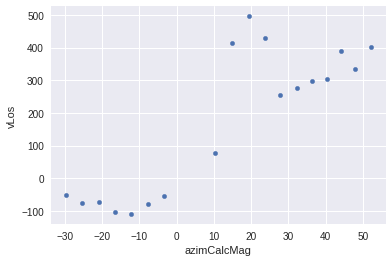

In [34]:
lshellDF = sapsDF[ sapsDF["date"] == sapsTime ]
selCols = [ "vLos", "MLAT", "normMLT", "azimCalcMag", "radCode", "beam" ]
lshellDF = lshellDF[selCols]
r1 = lshellDF[ lshellDF["radCode"].isin( ["fhw", "fhe"] ) ]
r1b = r1.groupby( ["radCode", "beam"] ).max().reset_index()
# get values from lats close by
r1b = r1b[ abs(r1b["MLAT"] - r1b["MLAT"].mean()) <= r1b["MLAT"].std() ]
# print r1b
r1b.plot( x="azimCalcMag", y="vLos", kind="scatter" )
print r1b